# Test examples of PL IFP computations

    1. Computing interaction fingerprints (IFP) for
        -- a single structure prepared for MD simulations (HSP90; PDB ID 6EI5, dcd format)
        -- a trajectory (for selected frames; dcd format)
        -- PDB structure
    2. Visualizing protein residues that are involved in protein-ligand interactions, including water-bridges
     

### Author: Daria Kokh
    v.1.0
    Copyright (c) 2019
    Released under the GNU Public Licence, v2 or any higher version
    


### Input data required:
    MD trajectory file of a complex
    pdb file of a complex (for example, generated from the first frame)
    pdb and mol2 file of a ligand separately 
    
    
### Packages required:
    numpy
    matplotlib
    MDAnalysis v. 20.1
    pandas
    seaborn
    RDkit
    code is written on Python 3.x and tested on the version 3.7



##  Application example 

    Heat Shock Protein 90 (HSP90)

Import all of the required packages and scripts

In [1]:
import glob, os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nglview as nv
import MDAnalysis as mda
import warnings
from rdkit import Chem, RDConfig
from rdkit.Chem.rdMolChemicalFeatures import MolChemicalFeatureFactory
from Scripts.IFP_generation import *
from Scripts.Trajectories import *
#from Scripts.Complex_structure import *
#from Scripts.Clustering import *

%load_ext autoreload
%autoreload 2
warnings.filterwarnings("ignore")

_ColormakerRegistry()

## 1. HSP90 structure (PDB ID 6EI5; prepared for MD simulations) without trajectory.py
### 1.1 find chemical properties of the ligand using RDKit 

Before we start with the IFP-Analysis we first need to extract the chemical information of the ligand.

In [2]:
# Define the path to the Ligand data, pdb file and mol2 file are needed
ligand_pdb = "Data/6EI5//INH.pdb"
ligand_mol2 = "Data/6EI5//moe.mol2"

# Get the atom names of the ligand
with open(ligand_pdb, 'r') as fasta_file: #Does ff stand for fasta file? 
    list_labels = [line.split()[2] for line in fasta_file.readlines() if line.split()[0]=='ATOM']

# Get the ligand features using RDKit feature factory
mol = Chem.rdmolfiles.MolFromMol2File(ligand_mol2, removeHs=False)
factory_name = os.path.join(RDConfig.RDDataDir, 'BaseFeatures.fdef')
factory = Chem.ChemicalFeatures.BuildFeatureFactory(factory_name)
features = factory.GetFeaturesForMol(mol)

# Create dictionary that maps Atoms to their features
properties = {feature.GetFamily():[] for feature in features}
for feature in features:
    current_atoms = [list_labels[atom_id] for atom_id in list(feature.GetAtomIds())]
    for atom in current_atoms:
        properties[feature.GetFamily()].append(atom)
        
# Additionally we need to load our protein/ligand complex into a MDAnalysis universe
ref_pdb = 'Data/6EI5/ref-min.pdb'
u = mda.Universe(ref_pdb)

### 1.2 Generate PL IFPs 
Now that we have all the chemical information for our ligand, we can start the actual IFP analysis.  
The possible interactions with their corresponding abbreviations are shown in the table below.  
  
| Abbreviation |    Type of interaction   |
|:---------------|:---------------------------|
|   HY  | Hydrophobic |
|  IP  |       Salt bridge (positive charge) |
|  IN  |       Salt bridge (negative charge) |
|  AR  |   $\pi$-stacking  |
|    |  Cation-$\pi$  |
|    |  $\pi$-Cation  |
|    |  $\pi$-Amide  |
|  HL  |  Halogen-$\pi$  |
|    |  Halogen-carboxyl  |
|    |  Halogen-Amide  |
|    |  Halogen-Sulfur  |
|  HD  |  Hydrogen-bond donor  |
|  HA  |  Hydrogen-bond acceptor  |
|  WB  |  Water bridge  |

For this we use the IFP and table_combine functions contained in the IFP_generation script.\
The IFP function takes a variety of inputs.\
We need to supply our universe,  the ligand residue name and the properties of our ligand and set RE to false. The other settings we'll leave on the default for now.\
The IPS function returns three values, a properties, a hydrogenbond and a waterbridge dataframe.

In [3]:
df_prop,df_HB,df_WB = IFP(u,"INH",properties,RE=False)
df_prop_complete = table_combine(df_HB,df_WB,df_prop,"INH")

Start HB analysis 11:07:44.856032
Start WB analysis 11:07:45.236004
Start collecting IFPs:  11:08:02.721256
Start building IFP table:  11:08:04.538915
IFP database is ready  11:08:04.541940


In [4]:
df_prop_complete

,time,HY_ALA39,HA_ASP77,WB_ASP77,HY_ILE80,HY_GLY81,WB_GLY81,HY_MET82,HY_ASP86,HY_LEU91,HY_ILE94,HY_PHE122,HY_VAL134,HY_TRP146,WB_THR168,WAT
0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,4


### 1.3 Print specific PL IFPs
\
Protein Residues that interact with the Ligand:

In [5]:
df_prop_complete.columns.tolist()

['time',
 'HY_ALA39',
 'HA_ASP77',
 'WB_ASP77',
 'HY_ILE80',
 'HY_GLY81',
 'WB_GLY81',
 'HY_MET82',
 'HY_ASP86',
 'HY_LEU91',
 'HY_ILE94',
 'HY_PHE122',
 'HY_VAL134',
 'HY_TRP146',
 'WB_THR168',
 'WAT']

Hydrogen bonds between the ligand and Protein (distance in Angstrom):

In [6]:
df_HB

,time,donor_index,acceptor_index,donor_resnm,donor_resid,donor_atom,acceptor_resnm,acceptor_resid,acceptor_atom,distance,angle
0,0.0,3295,1248,INH,208,H141,ASP,77,OD1,2.834688,169.151585
1,0.0,3295,1249,INH,208,H141,ASP,77,OD2,2.060964,137.979250


This is the complete IFP database.\
It contains Waterbridges between the ligand and THR168, ASP77 and GLY81.\
Hydrogen bonds and aromatic contact with the ligand are constituted with ASP77, and GLY81/MET82 respectively.

In [7]:
df_prop_complete

,time,HY_ALA39,HA_ASP77,WB_ASP77,HY_ILE80,HY_GLY81,WB_GLY81,HY_MET82,HY_ASP86,HY_LEU91,HY_ILE94,HY_PHE122,HY_VAL134,HY_TRP146,WB_THR168,WAT
0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,4


### 1.4 Visualization of protein residues involved in the PL interactions
For the visualization in jp notebook we'll use NGLWidget.\
Let's first look at all residues participating in protein-ligand water bridges and H-bonds (taken from df_HB and df_WB).

In [8]:
view = nv.NGLWidget()

# We only want to see the protein and the ligand
u_reduced = u.select_atoms('protein or (resname INH WAT)')
w=nv.show_mdanalysis(u_reduced)
w.add_licorice("77 81 168")
w

NGLWidget()

Next, let us look at aromatic interactions. The following can be adapted to other interactions by changing "AR" to one of "HD", "HA", "IP", "IN", "WB", "HA".

In [9]:
view = nv.NGLWidget()
u_reduced = u.select_atoms('protein or (resname INH WAT)')
w = nv.show_mdanalysis(u_reduced)

residues = ''.join([' ' + str(ifp[6:]) for ifp in df_prop_complete.columns.tolist() 
                    if (ifp[:2] == 'AR')])
print('Showing residues', residues)
w.add_licorice(residues)
w

Showing residues 


NGLWidget()

## 2. Generation of PL IFPs for a single MD trajectory
### 2.1 Read a trajectory, compute PL IFPs and show results
This time we'll calculate the IFPs not for a static situation, but over a trajectory. The procedure stays mainly the same as the above, with a few tweaks.

0 RMSD (protein , ligand): [1.8149448168239566, 0.9369309884009814] traj length: 1000
1 RMSD (protein , ligand): [1.8663876765455583, 1.3106771150193275] traj length: 1000
2 RMSD (protein , ligand): [1.824483371709505, 1.3678690520872283] traj length: 1000
3 RMSD (protein , ligand): [1.8584204150682104, 1.193052637550799] traj length: 1000
4 RMSD (protein , ligand): [1.8824416186044164, 1.467007339387443] traj length: 1000
5 RMSD (protein , ligand): [1.8235934222587904, 1.4605073710443868] traj length: 1000
6 RMSD (protein , ligand): [1.8676691534056542, 0.94039910440598] traj length: 1000
7 RMSD (protein , ligand): [1.8555510030471447, 0.8396326466471579] traj length: 1000
8 RMSD (protein , ligand): [1.9695548850571365, 1.2110487607244371] traj length: 1000
9 RMSD (protein , ligand): [1.8171787102327517, 1.5331365685448004] traj length: 1000
10 RMSD (protein , ligand): [1.955475792261257, 0.9194494890246193] traj length: 1000
11 RMSD (protein , ligand): [1.9383495567160693, 0.96845898

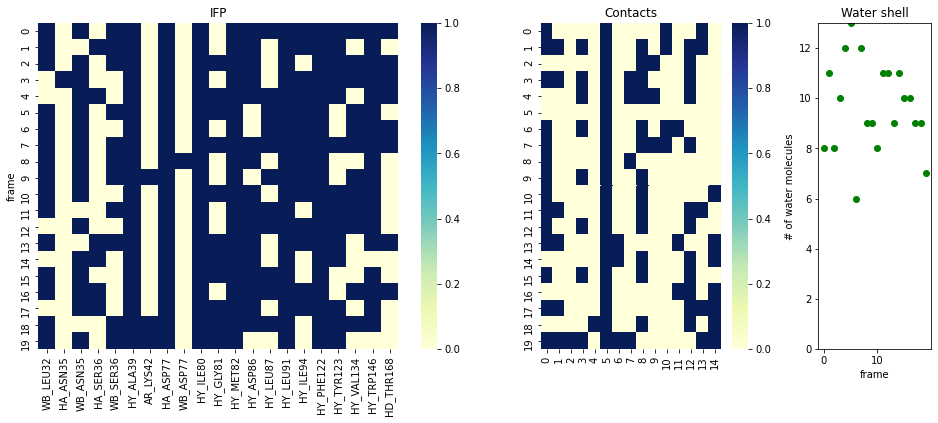

In [10]:
# Set the file paths for all of the needed data
ref_pdb = "Data/6EI5/ref-min.pdb"
ligand_pdb = "Data/6EI5//INH.pdb"
ligand_mol2 = "Data/6EI5//moe.mol2"
traj = "Data/6EI5/amber2namd2.dcd"

# Initialize the MDAnalysis Universes (static and with trajectory) and calculate the radius of gyration 
ref = mda.Universe(ref_pdb)
Rgyr_t0 = ref.select_atoms("protein").radius_of_gyration()

u = mda.Universe(ref_pdb,traj) 
u_length = len(u.trajectory)

# Load part of the trajectory in the memory
u_reduced = u.select_atoms('protein or (resname INH WAT)')    
stepsize = 50
u_mem = mda.Merge(u_reduced).load_new(AnalysisFromFunction(
            lambda ag: ag.positions.copy(), u_reduced).run(
                start=0,stop=-1,step=stepsize).results,format=MemoryReader)

# Bring the trajectory into the right format
# One can save selected snapshots in the pdb format
save_pdb = False  

for i in range(0,len(u_mem.trajectory),1):
    u_mem.trajectory[i]  
    u_mem.dimensions = u.dimensions
    
    # Wrap all atoms back to the box, use radius of gyration for checking whether the procedure was successful
    Rgyr = pbc(u_mem,Rgyr_t0)

    # Calculate Root-mean-square deviation
    rmsd = superimpose_traj(ref,u_mem,["protein","resname INH"])
    
    print(i,"RMSD (protein , ligand):",rmsd,"traj length:",u_length)
    
    if save_pdb == True:
        all_write = u.select_atoms("all")
        all_write.write("/hits/fast/mcm/kokhda/TMP/"+"/namd_protein-"+str(i)+".pdb")

# Compute IFP
df_prop,df_HB,df_WB = IFP(u_mem, "INH", properties, WB_analysis=True, RE=True, Lipids=[])

# Build IFP table
df_prop_complete = table_combine(df_HB, df_WB, df_prop, "INH")

# Plot IFPs
Plot_IFP(df_prop_complete, contact_collection=None)

### Explanation for the plots:  
The first plot shows the devlopment of detected IFPs over the time of the trajetorie.  
The second plot shows all contacts between ligand and protein over the time of the trajectorie.  
The third plot shows the amount of molecules participating in the water shell of the ligand.

### 2.2 PL IFP table
Now we take a look at our calculated tables.\
First we're gonna look at water molecules participating in protein-ligand water bridges.

In [11]:
water_bridges = df_WB[df_WB.sele2_resnm.isin(["INH","WAT"])]
water_bridges 

,time,sele1_index,sele2_index,sele1_resnm,sele1_resid,sele1_atom,sele2_resnm,sele2_resid,sele2_atom,distance,angle
2,0.0,3295,3315,INH,208,H141,WAT,264,O,3.007054,143.258686
4,0.0,3317,3318,WAT,264,H2,WAT,265,O,1.679101,165.651706
7,0.0,3318,3317,WAT,265,O,WAT,264,H2,1.679101,165.651706
8,0.0,3320,3321,WAT,265,H2,WAT,266,O,1.706522,165.457950
9,0.0,3295,3318,INH,208,H141,WAT,265,O,1.986871,150.195769
...,...,...,...,...,...,...,...,...,...,...,...
287,19.0,3296,3324,INH,208,H142,WAT,267,O,3.267007,126.809517
288,19.0,3268,3317,INH,208,N8,WAT,264,H2,2.361863,142.569471
289,19.0,3270,3325,INH,208,N10,WAT,267,H1,2.423445,125.716732
290,19.0,3264,4685,INH,208,O4,WAT,720,H2,1.579936,161.082026


In [12]:
df_WB.sele2_resnm.unique()

array(['ASP', 'WAT', 'ASN', 'LEU', 'SER', 'THR'], dtype=object)

### 2.3 Visualization of protein residues involved in PL interactions
For the last point of this part we are gonna visualize the residues that participate in the IFP.

In [13]:
# obtain string that contains unique residues interacting with water
watr = ''.join([resid+' ' for resid in np.unique(water_bridges.sele2_resid.values.astype(str))])

# obtain residues that participate in aromatic interaction
residues = ''.join([str(ifp[6:]+' ') for ifp in df_prop_complete.columns.tolist() 
                    if (ifp[:2] == 'AR')])
print("Showing Residues: ", residues)

# Visualize the Complex

view = nv.NGLWidget()
protein = u_mem.select_atoms('protein or (resname INH WAT)')
w=nv.show_mdanalysis(protein)
w.add_licorice(watr+residues)
w

Showing Residues:  42 


NGLWidget(max_frame=19)

## 3. Generation of IFPs for a PDB file               (HSP90, PDB ID: 2YKI)

Lastlz, We will use the trajectory.py script in order to get the properties of our ligand and another IFP analysis.

### 3.1 IFP calculations

In [14]:
# Define path to input data
ref_pdb = "Data/2YKI/2yki_MOE.pdb"
ligand_pdb_ = "Data/2YKI/ligand_2yki_MOE.pdb"
ligand_mol2 = "Data/2YKI/ligand_2yki_MOE.mol2"

# Load the pdb file into MDAnalysis universe
u = mda.Universe(ref_pdb)

# Define ligand residue name
sel_ligands = 'YKI'

# Get the chemical properties of the ligand with the ligand_properties function from the trajectories script
properties, mol = ligand_properties(ligand_pdb, ligand_mol2)
print(properties)

# IFP analysis, for reference look at 1. or 2.
df_prop,df_HB,df_WB = IFP(u,sel_ligands,properties,WB_analysis=True,RE=False)
df_prop_complete = table_combine(df_HB,df_WB,df_prop,sel_ligands)

# Summary for all interactions
ifp_type = ['HY','AR','WB','HA','HD']
at_type = [[],[],[],[],[]]
for v in df_prop_complete.columns.tolist():
    for i,t in enumerate(ifp_type):
        if v.find(t)>=0:
            at_type[i].append(v)
            
print('\n',10*'--','Contacts found:',10*'--')
print("\nHydrophobic contacts: ",at_type[0])
print("\nAromatic contacts: ",at_type[1])
print("\nWater Bridges: ",at_type[2])
print("\nHydrogen Acceptors: ",at_type[3])
print("\nHydrogen Donors: ",at_type[4])

{'Donor': ['O4', 'C6', 'N8', 'N10', 'C12'], 'Acceptor': ['C2', 'C6', 'N10', 'C19'], 'PosIonizable': ['C9', 'C6', 'C7', 'O4', 'C11'], 'Aromatic': ['O4', 'C7', 'C6', 'C9', 'C11', 'C12', 'H7', 'C31', 'H12', 'H9', 'C1', 'C2', 'N3', 'C11', 'C9', 'C5', 'N10', 'C21', 'C20', 'C18', 'C31', 'H7', 'C13', 'C16', 'C15', 'N14', 'C23', 'C24', 'C25', 'C26', 'C27', 'C28', 'C29', 'N30'], 'Hydrophobe': ['C5', 'C13', 'N14', 'C15', 'C16', 'C18', 'C20', 'C23', 'C24', 'C25', 'C26', 'C27', 'C28', 'C29', 'N30', 'C31', 'H12'], 'LumpedHydrophobe': ['C13', 'C16', 'C15', 'N14', 'C23', 'C24', 'C25', 'C26', 'C27', 'C28', 'C29', 'N30']}
Start HB analysis 11:15:46.762899
Start WB analysis 11:15:46.962004
Start collecting IFPs:  11:15:50.586655
Start building IFP table:  11:15:50.852275
IFP database is ready  11:15:50.854274

 -------------------- Contacts found: --------------------

Hydrophobic contacts:  ['HY_PHE22', 'HY_ASN51', 'HY_SER52', 'HY_ALA55', 'HY_MET98', 'HY_LEU107', 'HY_GLY108', 'HY_ILE110', 'HY_ALA111', 

In [15]:
df_prop_complete

,time,HY_PHE22,WB_GLN23,HY_ASN51,HY_SER52,HY_ALA55,HY_MET98,HY_LEU107,HY_GLY108,HY_ILE110,HY_ALA111,HY_VAL136,AR_PHE138,HY_PHE138,HY_TYR139,AR_TRP162,AR_PHE170,HY_THR184,HY_VAL186,WAT
0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,6


### 3.2 Visualization of PL interactions

In [16]:
view = nv.NGLWidget()
protein = u.select_atoms('all')
w=nv.show_mdanalysis(protein)
residues = "".join([str(ifp[6:] + " ") for ifp in df_prop_complete.columns.tolist()])
print("Showing residues: ", residues)
w.add_licorice(residues)
w

Showing residues:   22 23 51 52 55 98 107 108 110 111 136 138 138 139 162 170 184 186  


NGLWidget()